# Exercises

In [18]:
import numpy as np
import preliz as pz

# Exercise 1: Maternity Ward Planning

a) The Poisson distribution is an appropriate model if: $E[Y] = Var[Y] = \lambda$

In [19]:
y = np.array([6,11,12,9,11,10,9,18,9,18,12,14,9,11,10,15,13,11,14,12,11,8,11,13,11,12,20,5,13,16])
print(f"E[Y] = {y.mean()}, Var[Y] = {y.var()}, mean(E[Y], Var[Y]) = {(y.mean() + y.var()) / 2:.3f}")

E[Y] = 11.8, Var[Y] = 10.76, mean(E[Y], Var[Y]) = 11.280


Both are roughly the same, so we use $\lambda = 11.28$

For $\lambda \sim Gamma(s, r)$:

- $E[\lambda] = \dfrac{s}{r}$
- $Var[\lambda] = \dfrac{s}{r^2}$

And because we know $E[\lambda] = 15$ we can solve for $s$:

$$
\begin{align}
E[\lambda] &= \dfrac{s}{r}\\
15 &= \dfrac{s}{r}\\
s &= 15 \cdot r\\
\end{align}
$$

<Axes: >

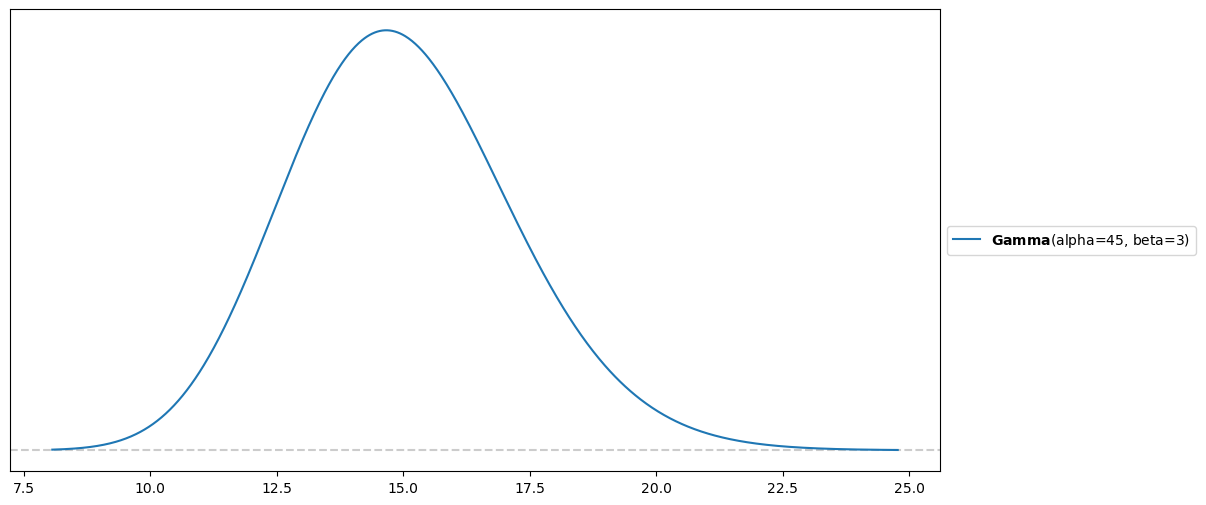

In [20]:
import preliz as pz

r = 3
s = 15 * r

pz.Gamma(s, r).plot_pdf(figsize=(12, 6))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambd,15.027,2.286,10.918,19.394,0.054,0.033,1763.0,2730.0,1.0


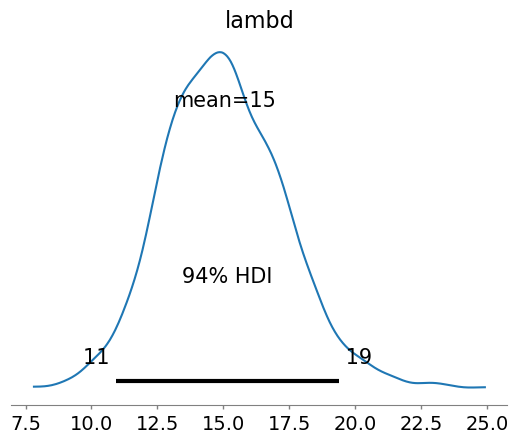

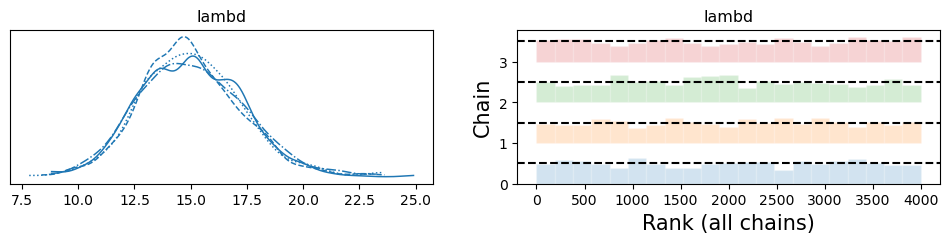

In [21]:
import pymc as pm
import arviz as az

# Disable C compilation by using the Python-only mode:
import pytensor
pytensor.config.cxx = ""

with pm.Model() as model:
    lambd = pm.Gamma('lambd', alpha = s, beta = r)
    samples = pm.sample(1000)

az.plot_posterior(samples)
az.plot_trace(samples, kind = "rank_bars")
az.summary(samples)

d) Full model:

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 4 seconds.


array([[<Axes: title={'center': 'lambd'}>,
        <Axes: title={'center': 'lambd'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

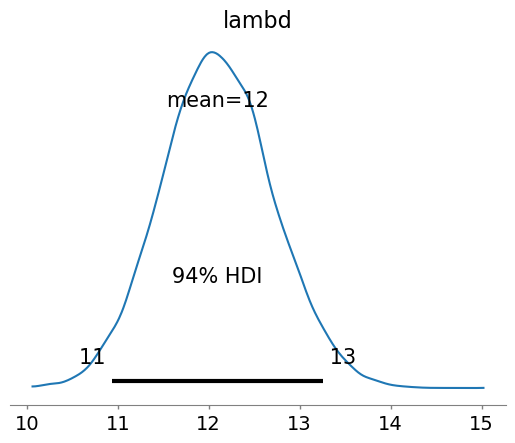

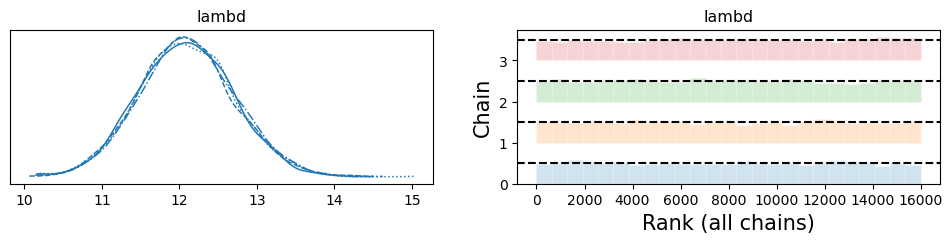

In [22]:
import pymc as pm
import arviz as az

# Disable C compilation by using the Python-only mode:
import pytensor
pytensor.config.cxx = ""

with pm.Model() as model:
    lambd = pm.Gamma('lambd', alpha = s, beta = r)
    y = pm.Poisson('y', mu = lambd, observed = [6,11,12,9,11,10,9,18,9,18,12,14,9,11,10,15,13,11,14,12,11,8,11,13,11,12,20,5,13,16])
    samples = pm.sample(4000)

az.plot_posterior(samples)
az.plot_trace(samples, kind = "rank_bars")

The chain ranks look good

array([[<Axes: title={'center': 'lambd'}>]], dtype=object)

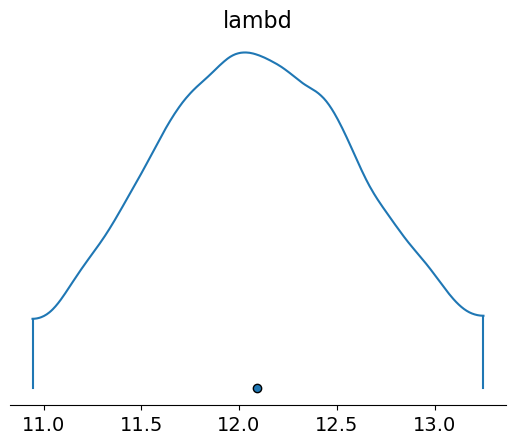

In [23]:
az.plot_density(samples)

The density plot looks good

<Axes: title={'center': 'lambd'}>

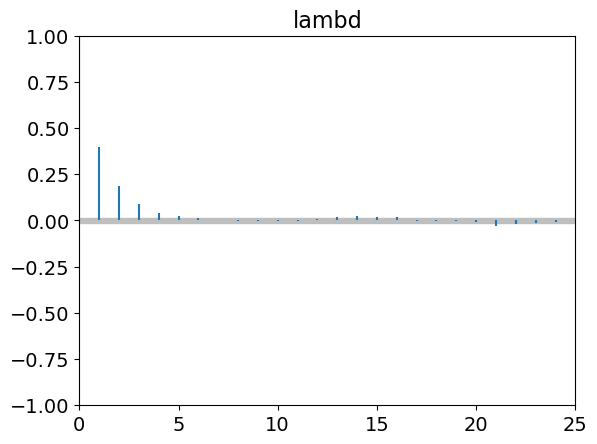

In [24]:
az.plot_autocorr(samples, max_lag = 25, combined = True)

The autocorrelation drops off very quickly, that's a good sign.

In [25]:
n = 16_000
ess = az.ess(samples).lambd.values
print(f"ess = {ess:.4f}, ess / n = {ess / n:.4f}")

ess = 6371.0387, ess / n = 0.3982


In [26]:
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambd,12.092,0.613,10.942,13.252,0.008,0.005,6371.0,10511.0,1.0


- ✅ Good: $\hat{R} < 1.05$ (We aim for it to be close to 1, because it means that the total variance is the same as the within variance)
- ✅ Good: $ESS / N > 10\%$: We do have approximately 41%

e)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambd,12.092,0.613,10.913,13.32,0.008,0.005,6371.0,10511.0,1.0


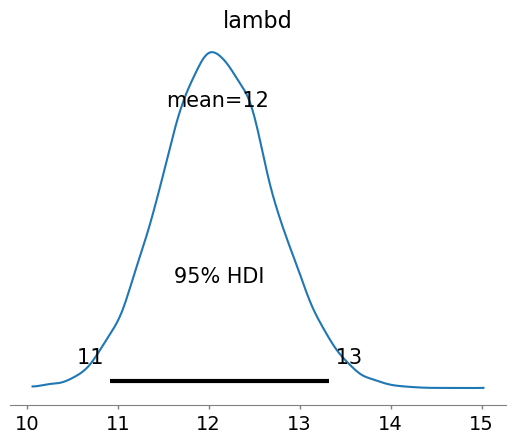

In [27]:
az.plot_posterior(samples, var_names = ['lambd'], hdi_prob = 0.95)
az.summary(samples, var_names = ['lambd'], hdi_prob = 0.95)

The posterior mean is 12 and the standard deviation is +/- 0.625 beds:

"I'm 95% confident that you'll need 11-13 beds most of the time. The average is somewhere in between - most likely 12. The standard deviation is very small; its only approximately half of a bed."

f)

In [28]:
with model:
    y_hat = pm.Poisson('y_hat', mu = lambd)
    predictions = pm.sample_posterior_predictive(samples, var_names = ['y_hat'])
predictions

Sampling: [y_hat]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data

In [39]:
365 * np.mean( predictions.posterior_predictive.y_hat > 20 ).values

np.float64(5.4521875)

g)

Aleatoric:

In [41]:
n = len([6,11,12,9,11,10,9,18,9,18,12,14,9,11,10,15,13,11,14,12,11,8,11,13,11,12,20,5,13,16])
aleatoric_vars = n * samples.posterior.lambd.values * (1 - samples.posterior.lambd.values)
aleatoric_var = np.mean(aleatoric_vars)
aleatoric_var

np.float64(-4035.3214847260315)

Epistemic:

In [42]:
epistemic_var = np.var(samples.posterior.lambd.values * n)
epistemic_var

np.float64(338.2771218067962)

Predictive:

In [43]:
pred_var = np.var(predictions.posterior_predictive.y_hat.values)
pred_var

np.float64(12.635044058593751)

Check:

In [44]:
pred_var - aleatoric_var

np.float64(4047.9565287846253)

Contributions in %:

In [45]:
np.round(np.array([aleatoric_var, epistemic_var]) / (aleatoric_var + epistemic_var) * 100, 1)

array([109.1,  -9.1])

Aleatoric variance dominates. Collecting more data doesn't help because most of the variance is due to uncertainty in the data itself.

# Exercise 2: Toilet Paper A/B Testing

### a)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, sigma_b, mu_a, sigma_a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_b,159.760,6.833,147.377,173.252,0.132,0.136,2768.0,2338.0,1.0
mu_a,145.906,6.013,134.746,157.545,0.116,0.123,2869.0,2340.0,1.0
sigma_b,17.417,6.412,8.723,29.121,0.126,0.169,2943.0,2674.0,1.0
sigma_a,15.333,5.651,7.298,25.615,0.115,0.172,3049.0,2584.0,1.0


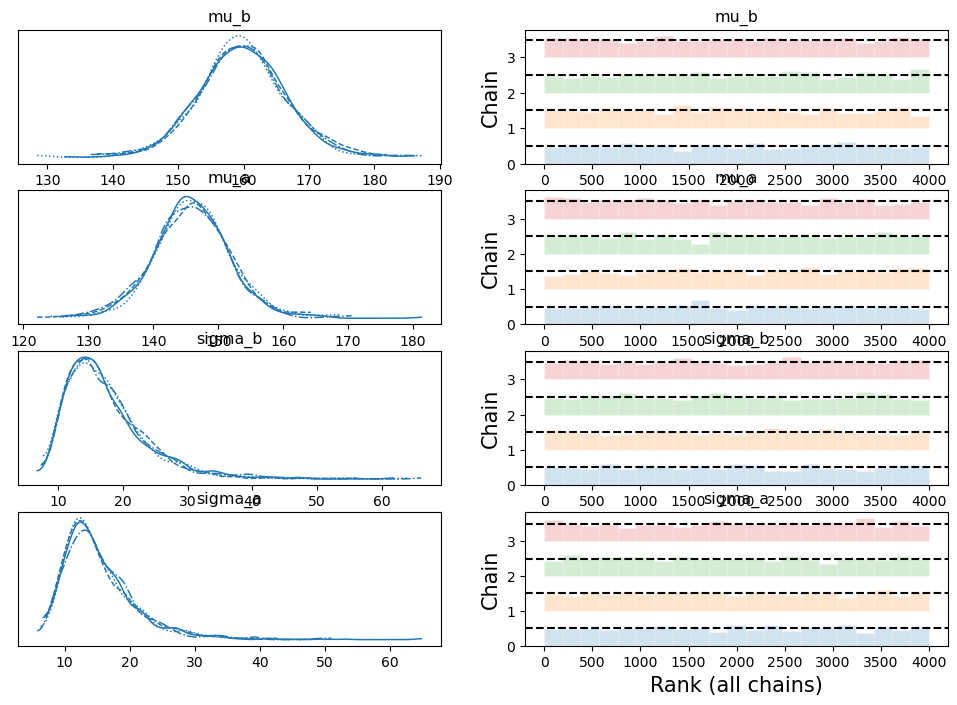

In [71]:
import numpy as np
import pymc as pm
import arviz as az

# Disable C compilation by using the Python-only mode:
import pytensor
pytensor.config.cxx = ""

y_b = [181,152,148,146,171]
y_b_mean = np.mean(y_b)
y_b_std = np.std(y_b, ddof = 1)

y_a = [163,153,146,126,142]
y_a_mean = np.mean(y_a)
y_a_std = np.std(y_a, ddof = 1)

with pm.Model() as model:
    mu_b = pm.Normal('mu_b', mu = y_b_mean, sigma = y_b_std)
    sigma_b = pm.Exponential('sigma_b', lam = 1/y_b_std)
    y_b_hat = pm.Normal('y_b_hat', mu = mu_b, sigma = sigma_b, observed = y_b)

    mu_a = pm.Normal('mu_a', mu = y_a_mean, sigma = y_a_std)
    sigma_a = pm.Exponential('sigma_a', lam = 1/y_a_std)
    y_a_hat = pm.Normal('y_a_hat', mu = mu_a, sigma = sigma_a, observed = y_a)

    samples = pm.sample(1000)

az.plot_trace(samples, kind = 'rank_bars')
az.summary(samples)

The plots look good!

### b)

<Axes: title={'center': 'x'}>

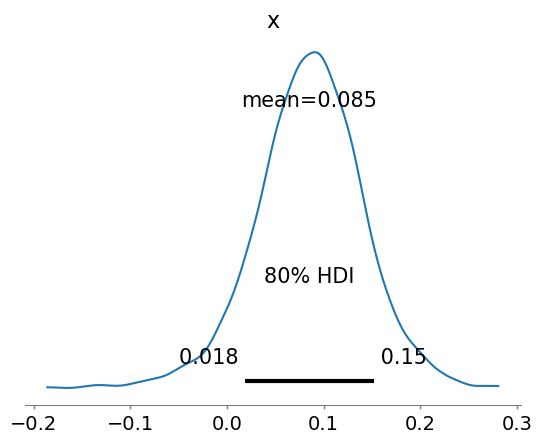

In [88]:
saved_relative_toilet_paper = (samples.posterior.mu_b - samples.posterior.mu_a) / samples.posterior.mu_b
az.plot_posterior(saved_relative_toilet_paper, hdi_prob = 0.80)

In [91]:
az.hdi(saved_relative_toilet_paper, hdi_prob=0.8).x.values

array([0.01846834, 0.15200656])

With 80% certainty, we save between 1% and 15% of toilet paper. Its a bit of a high uncertainty, but the data suggest that we at least save some paper.

### c)

- $H_0$: We save at least 20% of toilet paper
- $H_1$: We save less than 20% of toilet paper

In [96]:
pH1d = np.mean(saved_relative_toilet_paper.values < 0.2)
pH1d.round(3), (1 - pH1d).round(3)

(np.float64(0.982), np.float64(0.018))

The odds that $H_0$ is true is 1.8%. That said, the facility head did exaggerate.

### d)

- $H_0$: We save at least 10% of toilet paper
- $H_1$: We save less than 10% of toilet paper

In [98]:
pH1d = np.mean(saved_relative_toilet_paper.values < 0.1)
pH1d.round(3), (1 - pH1d).round(3)

(np.float64(0.607), np.float64(0.393))

The odds that $H_0$ is true are 39.3% percent. That said, its possible the facility head is right this time - but we'll have to gather more data to figure out.

# Exercise 3: Defective Screws

### a)

<Axes: >

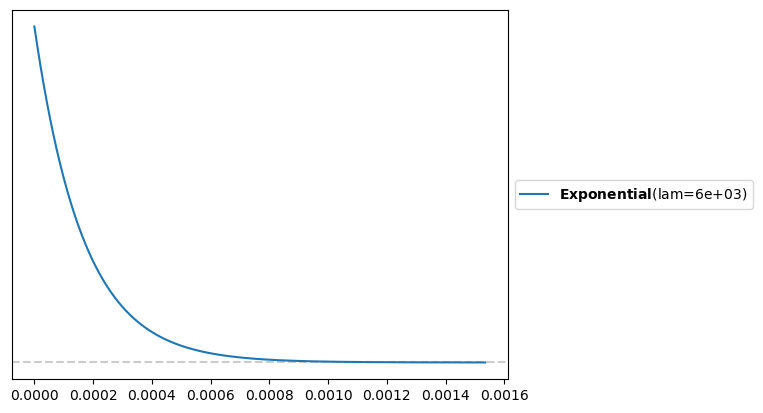

In [128]:
import preliz as pz

rate = 5 / 30_000

pz.Exponential(lam = 1 / rate).plot_pdf()

### b)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Output()

/Users/marbetschar/miniconda3/envs/bayesianmachinelearning/lib/python3.11/site-packages/pytensor/scalar/math.py:1340: RuntimeWarning: invalid value encountered in log
  return np.log(-np.expm1(x))
/Users/marbetschar/miniconda3/envs/bayesianmachinelearning/lib/python3.11/site-packages/pytensor/scalar/math.py:1340: RuntimeWarning: invalid value encountered in log
  return np.log(-np.expm1(x))
/Users/marbetschar/miniconda3/envs/bayesianmachinelearning/lib/python3.11/site-packages/pytensor/scalar/math.py:1340: RuntimeWarning: invalid value encountered in log
  return np.log(-np.expm1(x))


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'pi'}>,
        <Axes: title={'center': 'pi'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

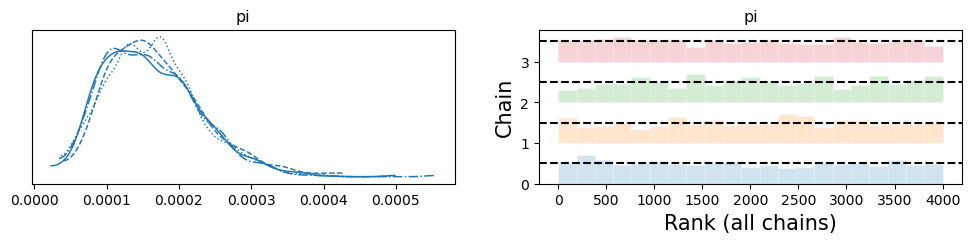

In [141]:
import pymc as pm
import arviz as az

# Disable C compilation by using the Python-only mode:
import pytensor
pytensor.config.cxx = ""

with pm.Model() as model:
    pi = pm.Exponential('pi', lam = 1 / rate)
    y = pm.Binomial('y', n = 30_000, p = pi, observed = 5)
    samples = pm.sample(1000)

az.plot_trace(samples, kind = 'rank_bars')

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi,0.0,0.0,0.0,0.0,0.0,0.0,1695.0,1749.0,1.0


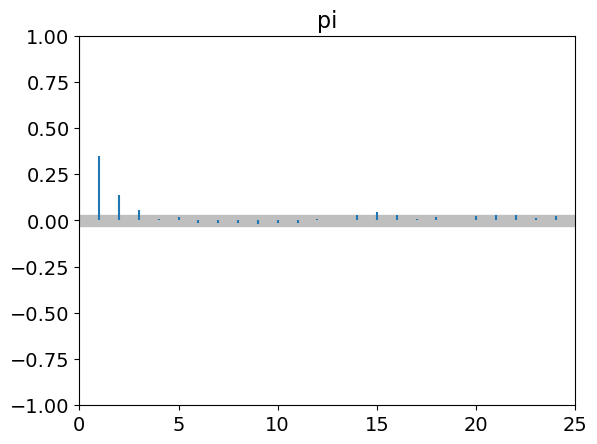

In [142]:
az.plot_autocorr(samples, max_lag = 25, combined = True)
az.summary(samples, hdi_prob = 0.90)

<Axes: title={'center': 'pi'}>

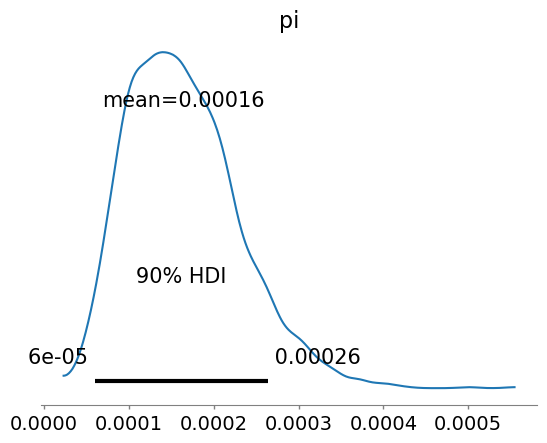

In [143]:
az.plot_posterior(samples, hdi_prob = 0.90)

With 90% certainty there will be between 0.00005 and 0.0003 defective screws within 30 days.

### c)

In [144]:
with model:
    y_hat = pm.Binomial('y_hat', n=30000, p=pi)
    predictions = pm.sample_posterior_predictive(samples, var_names=["y_hat"])

Sampling: [y_hat]


Output()

<Axes: title={'center': 'y_hat'}>

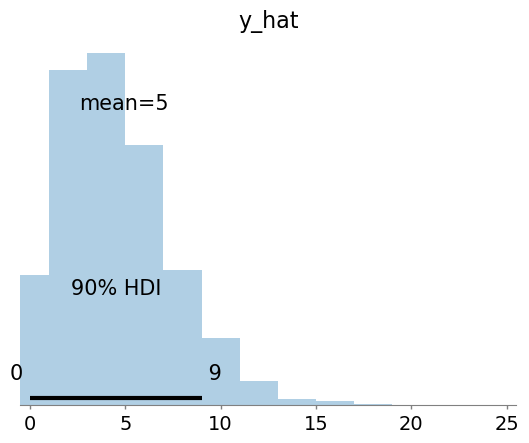

In [145]:
az.plot_posterior(predictions.posterior_predictive.y_hat, hdi_prob=0.9)

In [146]:
az.hdi(predictions.posterior_predictive.y_hat, hdi_prob=0.9).y_hat.values

array([0., 9.])

Within the next 30 days, I believe to 90% that between 0-9 screws will be defective.
